In [12]:
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt
import time
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.firefox.service import Service

In [13]:

def path2vec(pathstr):
    # this function is used to convert the raw engagement graph data to x, y vectors
    path_x = []
    path_y = []
    for item in pathstr.split("C"):
        if item.startswith("M"):
            continue
        item = item.strip()
        for dot in item.split(" ")[2:]:
            dot_x_y = dot.split(",")
            dot_x = float(dot_x_y[0])
            dot_y = 100-float(dot_x_y[1]) # the y axis is reversed
            path_x.append(dot_x)
            path_y.append(dot_y)
    return path_x, path_y

In [14]:
# id of video page to be scraped
yt_id = "Qx54quy9tDQ"
yt_video_url = "https://www.youtube.com/watch?v={}".format(yt_id)


In [15]:
## Obtain video engagment graphs (also referred to as "heatmap" in youtube video page html) ##
# Because the engagement graph is rendered by javascript, we need to use selenium to get the graph data

# the following code initializes the selenium webdriver
# DRIVER_PATH is the path to geckodriver.exe -- the Firefox WebDriver
DRIVER_PATH = "./selenium_webdriver_util/geckodriver.exe"

useragent = "Mozilla/5.0 (Linux; Android 8.0.0; Pixel 2 XL Build/OPD1.170816.004) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Mobile Safari/537.36"

options = webdriver.FirefoxOptions()
options.set_preference("dom.webnotifications.serviceworker.enabled", False)
options.set_preference("dom.webnotifications.enabled", False)
options.add_argument('--headless')
service = Service(executable_path=DRIVER_PATH)
driver = webdriver.Firefox(service=service, options=options)


In [16]:
# following code opens the youtube video page and collects the heatmap data
driver.get(yt_video_url)

# get time of data collection
time_str = str(datetime.now())
unix_time = int(time.time())

video_data = {"video_id": yt_id,
              "yt_video_url": yt_video_url,
               "collection_time_str": time_str,
             "collection_time_unix": unix_time,  
              }

delay = 20  # seconds

# because the heatmap section is loaded dynamically, we need to wait for it to load
try:
    heat_map_section_present = WebDriverWait(driver, delay).until(
        EC.presence_of_element_located((By.CLASS_NAME, "ytp-heat-map-chapter")))

    print(heat_map_section_present)

except TimeoutException:
    print("Exceeding load time limit!")


<selenium.webdriver.remote.webelement.WebElement (session="47916da9-e530-49a2-ab0f-88305aa2ca2d", element="b61f8473-b10c-4ef9-be96-96812af92543")>


In [17]:
# following code opens the youtube video page and collects the heatmap data
driver.get(yt_video_url)

# get time of data collection
time_str = str(datetime.now())
unix_time = int(time.time())

video_data = {"video_id": yt_id,
              "yt_video_url": yt_video_url,
               "collection_time_str": time_str,
             "collection_time_unix": unix_time,  
              }

delay = 20  # seconds

# because the heatmap section is loaded dynamically, we need to wait for it to load
try:
    heat_map_section_present = WebDriverWait(driver, delay).until(
        EC.presence_of_element_located((By.CLASS_NAME, "ytp-heat-map-chapter")))

    print(heat_map_section_present)

except TimeoutException:
    print("Exceeding load time limit!")

# once the heatmap section is loaded, we can extract the path data from the html
page = BeautifulSoup(driver.page_source, "html.parser")
driver.quit()

<selenium.webdriver.remote.webelement.WebElement (session="47916da9-e530-49a2-ab0f-88305aa2ca2d", element="73370a48-193f-4747-ab4a-82542fdb75ce")>


In [18]:

heat_map_section = page.find_all("div", {"class", "ytp-heat-map-chapter"})

print(heat_map_section)

# print(len(heat_map_section))
map_data_list = []
if heat_map_section:
    for chap_map in heat_map_section:
        chap_path_data = chap_map.find("path", {"class", "ytp-heat-map-path"}).get('d')
        map_data_list.append(chap_path_data)

# whether there are multiple chapters
if len(map_data_list) == 1:
    path_data = map_data_list[0]
    path_x, path_y = path2vec(path_data)
    video_data["path_data_raw"] = path_data
    video_data["path_x"] = path_x
    video_data["path_y"] = path_y
    video_data["graph_exist"] = True

elif len(map_data_list) > 1: # multiple chapters
    path_x_list = []
    path_y_list = []
    for path_data in map_data_list:
        path_x, path_y = path2vec(path_data)
        path_x_list.append(path_x)
        path_y_list.append(path_y)

    video_data["path_data_raw"] = map_data_list
    video_data["path_x"] = path_x_list
    video_data["path_y"] = path_y_list
    video_data["graph_exist"] = True

elif len(map_data_list) == 0: # no heatmap data
    video_data["path_data_raw"] = None
    video_data["path_x"] = None
    video_data["path_y"] = None
    video_data["graph_exist"] = False

[<div class="ytp-heat-map-chapter" style="width: 829px; left: 0px;"><svg class="ytp-heat-map-svg" height="100%" preserveaspectratio="none" style="height: 40px;" version="1.1" viewbox="0 0 1000 100" width="100%"><defs><clippath id="4"><path class="ytp-heat-map-path" d="M 0.0,100.0 C 1.0,87.2 2.0,40.6 5.0,35.9 C 8.0,31.2 11.0,66.7 15.0,76.6 C 19.0,86.6 21.0,83.0 25.0,85.6 C 29.0,88.1 31.0,88.4 35.0,89.3 C 39.0,90.2 41.0,89.9 45.0,90.0 C 49.0,90.1 51.0,90.0 55.0,90.0 C 59.0,90.0 61.0,90.0 65.0,90.0 C 69.0,90.0 71.0,90.0 75.0,90.0 C 79.0,90.0 81.0,90.0 85.0,90.0 C 89.0,90.0 91.0,90.5 95.0,90.0 C 99.0,89.5 101.0,89.3 105.0,87.3 C 109.0,85.4 111.0,80.5 115.0,80.3 C 119.0,80.2 121.0,84.6 125.0,86.6 C 129.0,88.5 131.0,89.3 135.0,90.0 C 139.0,90.7 141.0,90.9 145.0,90.0 C 149.0,89.1 151.0,87.0 155.0,85.7 C 159.0,84.4 161.0,83.9 165.0,83.5 C 169.0,83.0 171.0,82.3 175.0,83.6 C 179.0,84.9 181.0,88.7 185.0,90.0 C 189.0,91.3 191.0,90.9 195.0,90.0 C 199.0,89.0 201.0,85.7 205.0,85.2 C 209.0,84.8 211.0,

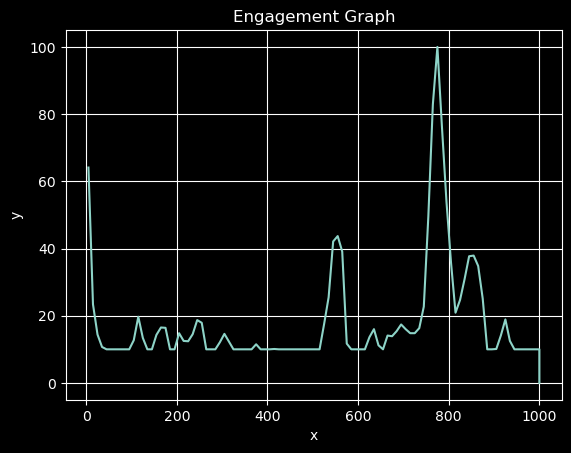

In [19]:
# visualize the engagment graph
if video_data["graph_exist"]:
    fig, ax = plt.subplots()
    if len(map_data_list) == 1:
        ax.plot(path_x, path_y)
    else:
        for i in range(len(path_x_list)):
            ax.plot(path_x_list[i], path_y_list[i])

    ax.set(xlabel='x', ylabel='y',
           title='Engagement Graph')
    ax.grid()
    plt.show()

In [20]:
# save video data to json file
with open('./video_data/yt_engagment_graph_{}.json'.format(yt_id), 'w') as fid:
    json.dump(video_data, fid)